<a href="https://colab.research.google.com/github/guilhermecgs/apdoac/blob/master/apdoac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dados da tese de mestrado APDOAC

In [16]:
!npx degit guilhermecgs/apdoac/dados -f

npx: installed 1 in 1.316s
> destination directory is not empty. Using --force, continuing
> cloned guilhermecgs/apdoac#master


In [36]:
! pip install pandas
! pip install tqdm
! pip install xlsx2csv

     |████████████████████████████████| 245kB 2.8MB/s 
  Created wheel for xlsx2csv: filename=xlsx2csv-0.7.7-cp36-none-any.whl size=44870 sha256=88012ccd5c56703dd0a2a843f9fd4376c2b3a8f3c2925a2f2d2f0a5e76bc0cfe
  Stored in directory: /root/.cache/pip/wheels/9f/d1/6e/1b6cbf7dcfe72469d95f2cd331a373e8e2fde30a5946d61dfd
Successfully built xlsx2csv


In [28]:
import pandas as pd


In [45]:
import os
import glob
from tqdm.notebook import trange, tqdm
from xlsx2csv import Xlsx2csv
  

def concat(pathname):
  arquivos = glob.glob(pathname)
  print('Unindo arquivos:')
  print('\n    -'.join(arquivos))

  dfs = []
  for arquivo in tqdm(arquivos):
    arquivo_csv = arquivo.replace('xlsx', 'csv')
    if not os.path.isfile(arquivo_csv):
      Xlsx2csv(arquivo, outputencoding="utf-8").convert(arquivo.replace('xlsx', 'csv'))

    dfs.append(pd.read_csv(arquivo_csv))
    
  return pd.concat(dfs)


In [46]:
df_discentes = concat('discente/*.xlsx')



Unindo arquivos:
discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2014.xlsx
    -discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2016.xlsx
    -discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2013.xlsx
    -discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2015.xlsx


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [57]:
print(len(df_discentes[(df_discentes['NM_GRANDE_AREA_CONHECIMENTO'] == 'ENGENHARIAS') 
                        & (df_discentes['AN_BASE'] == 2016)
                        & (df_discentes['TP_SEXO_DISCENTE'] == 'FEMININO')
                        ].index))


15129




1.   Verificando como ficara teste XYZ



In [48]:
df_discentes

,AN_BASE,NM_GRANDE_AREA_CONHECIMENTO,CD_AREA_AVALIACAO,NM_AREA_AVALIACAO,CD_ENTIDADE_CAPES,CD_ENTIDADE_EMEC,SG_ENTIDADE_ENSINO,NM_ENTIDADE_ENSINO,CS_STATUS_JURIDICO,DS_DEPENDENCIA_ADMINISTRATIVA,NM_MODALIDADE_PROGRAMA,NM_GRAU_PROGRAMA,CD_PROGRAMA_IES,NM_PROGRAMA_IES,NM_REGIAO,SG_UF_PROGRAMA,NM_MUNICIPIO_PROGRAMA_IES,CD_CONCEITO_PROGRAMA,CD_CONCEITO_CURSO,ID_PESSOA,TP_DOCUMENTO_DISCENTE,NR_DOCUMENTO_DISCENTE,NM_DISCENTE,NM_PAIS_NACIONALIDADE_DISCENTE,DS_TIPO_NACIONALIDADE_DISCENTE,TP_SEXO_DISCENTE,AN_NASCIMENTO_DISCENTE,DS_FAIXA_ETARIA,DS_GRAU_ACADEMICO_DISCENTE,ST_INGRESSANTE,NM_SITUACAO_DISCENTE,DT_MATRICULA_DISCENTE,DT_SITUACAO_DISCENTE,QT_MES_TITULACAO,NM_TESE_DISSERTACAO,NM_ORIENTADOR,ID_ADD_FOTO_PROGRAMA,ID_ADD_FOTO_PROGRAMA_IES
0,2014,CIÊNCIAS BIOLÓGICAS,9,CIÊNCIAS BIOLÓGICAS III,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,FEDERAL,PÚBLICA,ACADÊMICO,MESTRADO/DOUTORADO,10001018002P1,BIOLOGIA EXPERIMENTAL,NORTE,RO,PORTO VELHO,3,3,834339,CPF,***.528.062-**,ANDONAI KRAUZE DE FRANCA,BRASIL,BRASILEIRO,MASCULINO,1977,35 A 39 ANOS,DOUTORADO,SIM,MATRICULADO,07MAY2014:00:00:00,07MAY2014:00:00:00,0,NÃO SE APLICA,NÃO SE APLICA,52358,115724
1,2014,MULTIDISCIPLINAR,49,CIÊNCIAS AMBIENTAIS,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,FEDERAL,PÚBLICA,ACADÊMICO,MESTRADO,10001018017P9,CIÊNCIAS AMBIENTAIS,NORTE,RO,ROLIM DE MOURA,3,3,1460252,CPF,***.492.512-**,RICHELLY GISELA PASQUALOTTO TEIXEIRA,BRASIL,BRASILEIRO,FEMININO,1991,20 A 24 ANOS,MESTRADO,SIM,MATRICULADO,18AUG2014:00:00:00,18AUG2014:00:00:00,0,NÃO SE APLICA,NÃO SE APLICA,51138,114408
2,2014,MULTIDISCIPLINAR,48,BIOTECNOLOGIA,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,FEDERAL,PÚBLICA,ACADÊMICO,DOUTORADO,12001015038P1,BIODIVERSIDADE E BIOTECNOLOGIA - REDE BIONORTE,NORTE,RO,PORTO VELHO,4,4,437724,CPF,***.757.282-**,LEIDIANE CAROLINE LAUTHARTTE,BRASIL,BRASILEIRO,FEMININO,1987,25 A 29 ANOS,DOUTORADO,SIM,MATRICULADO,03MAR2014:00:00:00,03MAR2014:00:00:00,0,NÃO SE APLICA,NÃO SE APLICA,49200,112306
3,2014,MULTIDISCIPLINAR,48,BIOTECNOLOGIA,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,FEDERAL,PÚBLICA,ACADÊMICO,DOUTORADO,12001015038P1,BIODIVERSIDADE E BIOTECNOLOGIA - REDE BIONORTE,NORTE,RO,PORTO VELHO,4,4,834154,CPF,***.738.490-**,TIAGO LUIZ KUNZ,BRASIL,BRASILEIRO,MASCULINO,1978,35 A 39 ANOS,DOUTORADO,NÃO,MATRICULADO,01MAR2013:00:00:00,01MAR2013:00:00:00,0,NÃO SE APLICA,NÃO SE APLICA,49200,112306
4,2014,CIÊNCIAS HUMANAS,36,GEOGRAFIA,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,FEDERAL,PÚBLICA,ACADÊMICO,MESTRADO/DOUTORADO,10001018005P0,GEOGRAFIA,NORTE,RO,PORTO VELHO,4,4,808297,CPF,***.314.602-**,GRACIMAR MOREIRA DE ALENCAR,BRASIL,BRASILEIRO,FEMININO,1976,35 A 39 ANOS,MESTRADO,NÃO,MATRICULADO,27FEB2013:00:00:00,27FEB2013:00:00:00,0,NÃO SE APLICA,NÃO SE APLICA,51247,114505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338030,2015,CIÊNCIAS DA SAÚDE,22,SAÚDE COLETIVA,53044002,NI,EGS/FIOCRUZ BRASÍLIA,ESCOLA DE GOVERNO EM SAÚDE/DIRETORIA REGIONAL ...,FEDERAL,PÚBLICA,PROFISSIONAL,MESTRADO PROFISSIONAL,53044002001P7,POLÍTICAS PÚBLICAS EM SAÚDE,CENTRO-OESTE,DF,BRASÍLIA,3,3,2384659,CPF,***.344.276-**,MICHELLY EUSTAQUIA DO CARMO,BRASIL,BRASILEIRO,FEMININO,1984,30 A 34 ANOS,MESTRADO PROFISSIONAL,SIM,MATRICULADO,03AUG2015:00:00:00,03AUG2015:00:00:00,0,NÃO SE APLICA,NÃO SE APLICA,50913,114183
338031,2015,CIÊNCIAS DA SAÚDE,22,SAÚDE COLETIVA,53044002,NI,EGS/FIOCRUZ BRASÍLIA,ESCOLA DE GOVERNO EM SAÚDE/DIRETORIA REGIONAL ...,FEDERAL,PÚBLICA,PROFISSIONAL,MESTRADO PROFISSIONAL,53044002001P7,POLÍTICAS PÚBLICAS EM SAÚDE,CENTRO-OESTE,DF,BRASÍLIA,3,3,1862297,CPF,***.049.747-**,MONICA ROCHA GONCALVES,BRASIL,BRASILEIRO,FEMININO,1982,30 A 34 ANOS,MESTRADO PROFISSIONAL,SIM,MATRICULADO,03AUG2015:00:00:00,03AUG2015:00:00:00,0,NÃO SE APLICA,NÃO SE APLICA,50913,114183
338032,2015,CIÊNCIAS DA SAÚDE,22,SAÚDE COLETIVA,53044002,NI,EGS/FIOCRUZ BRASÍLIA,ESCOLA DE GOVERNO EM SAÚDE/DIRETORIA RE

In [ ]:
df_docentes = concat('doscente/*.xlsx')

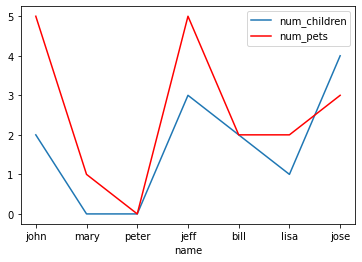

In [58]:
import pandas as pd

df = pd.DataFrame({
    'name':['john','mary','peter','jeff','bill','lisa','jose'],
    'age':[23,78,22,19,45,33,20],
    'gender':['M','F','M','M','M','F','M'],
    'state':['california','dc','california','dc','california','texas','texas'],
    'num_children':[2,0,0,3,2,1,4],
    'num_pets':[5,1,0,5,2,2,3]
})

import matplotlib.pyplot as plt
import pandas as pd

# gca stands for 'get current axis'
ax = plt.gca()

df.plot(kind='line',x='name',y='num_children',ax=ax)
df.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.show()